In [417]:
import numpy as np
import pandas as pd
from linearmodels import PanelOLS
import statsmodels.api as sm
from scipy import stats

In [2]:
df_New_Main = pd.read_excel('TAMU_NewForm_Main_20170817.xlsx')
df_Old_Main = pd.read_excel('TAMU_OldForm_Main_20170817.xlsx')
df_PCG_Data = pd.read_csv('PCG_Donor_Data2.csv')

In [9]:
#do all renaming here
df_PCG_All = df_PCG_Data.rename(index=str, columns = {"Unnamed: 0" : "org_name"})
df_Old_All = df_Old_Main.rename(index=str, columns = {"ein" : "EIN"})[['org_name', 'EIN', 'FiscalYearEnd',
                                                      'NTEECODE', 'government_grants', 
                                                      'service_revenue', 'membership_dues', 'fundraising']]
df_New_All = df_New_Main.rename(index=str, columns = {"ORGNAME" : "org_name"})[['org_name', 'EIN', 'FiscalYearEnd', 
                                                      'NTEECODE', 'FED_CAMPAIGNS', 'MEMBERSHIP_DUES', 
                                                      'TOTAL_FUNDRAISING', 'RELATED_ORGS', 'GOV_GRANTS', 'CONTRIB_OTHER', 
                                                      'CONTRIB_NONCASH', 'CONTRIB_ALL', 'SERVICE_REVENUE']].rename(index=str, columns = {"MEMBERSHIP_DUES" : "membership_dues", 
                                                                           "GOV_GRANTS" : "government_grants", 
                                                                           "SERVICE_REVENUE" : "service_revenue", "TOTAL_FUNDRAISING" : "fundraising"})

In [10]:
#aggregate summing of repeated EINs
df_PCG_All.loc[df_PCG_All['EIN'] == '23-7394620', 'org_name'] = 'University of Alaska'
df_PCG_All.loc[df_PCG_All['EIN'] == '92-0155067', 'org_name'] = 'Alaska Community Foundation'
df_PCG_All.loc[df_PCG_All['EIN'] == '92-0152088', 'org_name'] = 'Alaska Medical Missions CHA'
df_PCG_All.loc[df_PCG_All['EIN'] == '92-6001185', 'org_name'] = 'Crime Victim Compensation Fund'
df_PCG_All = df_PCG_All.groupby(['EIN','org_name'], as_index = False).sum()
#grouped so each EIN appears 1 time
#604 unique organizations by EIN (df_PCG_All['EIN'].nunique())

In [339]:
#new is 2007 - 2015
#old is 1998 - 2008
df_New_reg = df_New_All[['EIN', 'FiscalYearEnd', 'membership_dues', 
                                    'government_grants', 'service_revenue', 'fundraising']].fillna(0)
df_Old_reg = df_Old_All[['EIN', 'FiscalYearEnd', 'membership_dues', 
                                    'government_grants', 'service_revenue', 'fundraising']].fillna(0)

In [340]:
#invert PCG data
df_vert_PCG = pd.melt(df_PCG_All, id_vars=['EIN', 'org_name'], value_vars=['2009','2010','2011','2012','2013',
                                    '2014','2015','2016','2017','2018'], var_name = 'Year', value_name = 'Raised')

In [341]:
#assume year started is min year where raised > 0
df_PCG_NOZERO = df_vert_PCG[df_vert_PCG['Raised'] != 0]
df_PCG_Start = df_PCG_NOZERO.groupby('EIN', as_index=False)['Year'].min().rename(index=str, columns = {"Year": "PCGStartYear"})

In [343]:
df_PCG_Start.head(3)

,EIN,PCGStartYear
0,03-0382080,2011
1,03-0400265,2014
2,05-0591944,2009


In [342]:
#add the old and new together
df_reg = pd.concat([df_New_reg, df_Old_reg], ignore_index = True)

In [362]:
#adding TREATMENT dummy
df_reg['PCG_Treatment'] = df_reg['EIN'].isin(df_PCG_Start['EIN']).astype(int)
df_reg_PCGStart = df_reg.merge(df_PCG_Start, on = 'EIN', how='left').fillna(0)
#make sure int
df_reg_PCGStart['PCGStartYear'] = df_reg_PCGStart['PCGStartYear'].astype(int)

In [476]:
#add the POST_TREATMENT dummy
df_reg_PCGStart['PostTreatment'] = 0
#want to do anything about mid year ends???? below (some pcg donations may come after midyear fiscal end)
#if not in treatment - post_treatment is 1 if year after 2008
df_reg_PCGStart.loc[df_reg_PCGStart['PCG_Treatment'] == False, 'PostTreatment'] = \
                                    (df_reg_PCGStart['FiscalYearEnd'] > 2008).astype(int)
#if in treatment - post_treatment is 1 if year on/after PCGStartYear
df_reg_PCGStart.loc[df_reg_PCGStart['PCG_Treatment'] == True, 'PostTreatment'] = \
                                    (df_reg_PCGStart['FiscalYearEnd'] >= df_reg_PCGStart['PCGStartYear']).astype(int)
#NOW POSTTREATMENT IS CORRECT AND PCG_TREATMENT IS CORRECT

In [477]:
#add columns for depvar and interaction
df_reg_PCGStart['total_donations'] = df_reg_PCGStart['membership_dues'] + \
                                     df_reg_PCGStart['government_grants'] + df_reg_PCGStart['service_revenue']
df_reg_PCGStart['total_donations_NO_GG'] = df_reg_PCGStart['membership_dues'] + \
                                           df_reg_PCGStart['service_revenue']
df_reg_PCGStart['PostTreatment*PCG_Treatment'] = df_reg_PCGStart['PostTreatment'] * df_reg_PCGStart['PCG_Treatment']

In [478]:
#Add giving via pcg
df_PCG_Raised = df_vert_PCG[['EIN', 'Year', 'Raised']].rename(index=str,columns={"Year" : "FiscalYearEnd"})
df_reg_PCGStart['FiscalYearEnd'] = df_reg_PCGStart['FiscalYearEnd'].astype(int)
df_PCG_Raised['FiscalYearEnd'] = df_PCG_Raised['FiscalYearEnd'].astype(int)
df_reg_Raised = pd.merge(df_reg_PCGStart,df_PCG_Raised, on = ['EIN', 'FiscalYearEnd'], how = 'left').fillna(0)

In [493]:
#drop EIN if has 0 total donations for all years*****
#df_reg_Raised = df_reg_Raised.groupby(['EIN'],as_index = False).filter(lambda x: x['total_donations'].sum() != 0)
#not sure I want to do this before checking if EIN has all years
df_reg_Raised = df_reg_Raised[(df_reg_Raised['total_donations'] != 0) & (df_reg_Raised['total_donations_NO_GG'] != 0)]

In [497]:
df_reg_Raised_NO.shape

(42061, 13)

In [ ]:
#df_reg_Raised.groupby('EIN',sort=True).filter(lambda x: x['FiscalYearEnd'].size == 18).groupby('EIN')['total_donations'].sum().value_counts()

In [496]:
#making a copy of df_reg_Raised where outliers are removed
#df[np.abs(df.Data-df.Data.mean()) <= (3*df.Data.std())]
df_reg_Raised_NO = df_reg_Raised[
    (np.abs(df_reg_Raised['membership_dues'] - df_reg_Raised['membership_dues'].mean()) <= 
                                                                    (3*df_reg_Raised['membership_dues'].std())) &
    (np.abs(df_reg_Raised['government_grants'] - df_reg_Raised['government_grants'].mean()) <= 
                                                                    (3*df_reg_Raised['government_grants'].std())) &
    (np.abs(df_reg_Raised['service_revenue'] - df_reg_Raised['service_revenue'].mean()) <= 
                                                                    (3*df_reg_Raised['service_revenue'].std())) &
    (np.abs(df_reg_Raised['fundraising'] - df_reg_Raised['fundraising'].mean()) <= 
                                                                    (3*df_reg_Raised['fundraising'].std())) &
    (np.abs(df_reg_Raised['total_donations'] - df_reg_Raised['total_donations'].mean()) <= 
                                                                    (3*df_reg_Raised['total_donations'].std())) &
    (np.abs(df_reg_Raised['total_donations_NO_GG'] - df_reg_Raised['total_donations_NO_GG'].mean()) <= 
                                                                    (3*df_reg_Raised['total_donations_NO_GG'].std()))]

In [436]:
#removed around 1000 rows of outliers
#df_reg_Raised_NO.shape


In [498]:
#1998 - 2015 (18 years)  only 330 EIN's that appear in all 18 years (7 of them have 0 tot_don for all years)above
#this next line balances by removing EINs that dont have lall 18 yrs of data
df_reg_balanced = df_reg_Raised.groupby('EIN',sort=True).filter(lambda x: x['FiscalYearEnd'].size == 18).set_index(['EIN', 'FiscalYearEnd']).sort_index()
df_reg_balanced_NO = df_reg_Raised_NO.groupby('EIN',sort=True).filter(lambda x: x['FiscalYearEnd'].size == 18).set_index(['EIN', 'FiscalYearEnd']).sort_index()

#df_reg_balanced.groupby('EIN').size()
#FINAL DATASET FOR REGRESSION
mydata = df_reg_balanced[['total_donations_NO_GG','fundraising','PostTreatment','PCG_Treatment',
                          'Raised','PostTreatment*PCG_Treatment', 'government_grants']]
mydata_NO = df_reg_balanced_NO[['total_donations_NO_GG','fundraising','PostTreatment','PCG_Treatment',
                          'Raised','PostTreatment*PCG_Treatment', 'government_grants']]


In [499]:
#regression
y = mydata.total_donations_NO_GG #NOT INCLUDEING RAISED or GOV GRANNTs BELOW
x = mydata[['fundraising','PostTreatment','PCG_Treatment','PostTreatment*PCG_Treatment']]
mod = PanelOLS(y, x, time_effects = True, entity_effects=False) #cant use firm FE - perf collinear to TREATMENT
res = mod.fit(cov_type='clustered', cluster_entity=True)  #clustering by EIN???? correct?
print(res)

                            PanelOLS Estimation Summary                            
Dep. Variable:     total_donations_NO_GG   R-squared:                        0.0021
Estimator:                      PanelOLS   R-squared (Between):              0.0045
No. Observations:                   3780   R-squared (Within):               0.0081
Date:                   Wed, Apr 10 2019   R-squared (Overall):              0.0053
Time:                           19:58:00   Log-likelihood                -7.497e+04
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      1.9712
Entities:                            210   P-value                           0.0961
Avg Obs:                          18.000   Distribution:                  F(4,3758)
Min Obs:                          18.000                                           
Max Obs:                          18.000   F-statistic (robust):            

In [ ]:
#says pcg orgs losing 5mil after joining but outliers are screwing as seen in finalizeData

In [500]:
mydata_noi = mydata.reset_index()

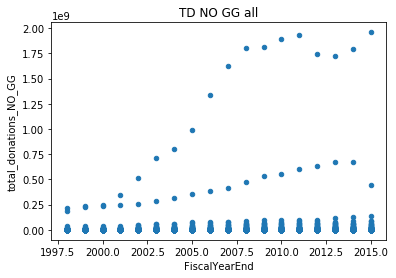

In [501]:
plt = mydata_noi.plot.scatter(x = 'FiscalYearEnd', y = 'total_donations_NO_GG', title= 'TD NO GG all')

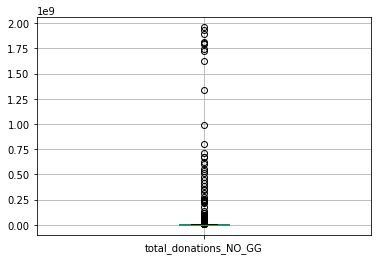

In [502]:
#this shows issue - so many outlier
bp = mydata_noi.boxplot(column='total_donations_NO_GG')

In [513]:
##NOW WILL REMOVE OUTLIERS
#regression
y = mydata_NO.total_donations_NO_GG #NOT INCLUDEING RAISED or GOV GRANNTs BELOW
x = mydata_NO[['fundraising','PostTreatment','PCG_Treatment','PostTreatment*PCG_Treatment']]
mod = PanelOLS(y, x, time_effects = True, entity_effects=False) #cant use firm FE - perf collinear to TREATMENT
res = mod.fit(cov_type='robust', cluster_entity=True)  #clustering by EIN???? correct?
print(res)

                            PanelOLS Estimation Summary                            
Dep. Variable:     total_donations_NO_GG   R-squared:                        0.0021
Estimator:                      PanelOLS   R-squared (Between):             -0.0270
No. Observations:                   3312   R-squared (Within):              -0.0294
Date:                   Wed, Apr 10 2019   R-squared (Overall):             -0.0276
Time:                           20:00:40   Log-likelihood                -5.816e+04
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      1.7369
Entities:                            184   P-value                           0.1390
Avg Obs:                          18.000   Distribution:                  F(4,3290)
Min Obs:                          18.000                                           
Max Obs:                          18.000   F-statistic (robust):            

In [506]:
mydata_NO[mydata_NO['total_donations_NO_GG'] == 0].shape

(0, 7)

In [507]:
mydata_NO_noi = mydata_NO.reset_index()

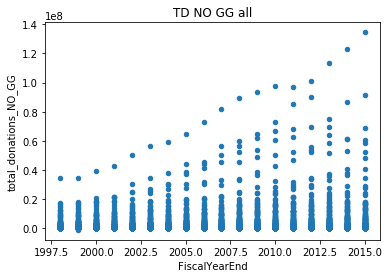

In [508]:
plt = mydata_NO_noi.plot.scatter(x = 'FiscalYearEnd', y = 'total_donations_NO_GG', title= 'TD NO GG all')
#constant dollars?????

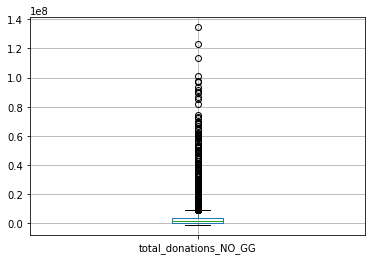

In [509]:
#this shows issue - so many outlier
bp = mydata_NO_noi.boxplot(column='total_donations_NO_GG')